# 1. Decision trees
Decision trees are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of the label of unseen data by learning simple decision rules inferred from the data features.

You can understand it as using a set of _if-then-else_ decision rules, e.g., _if_ it snowed in London, _then_ many Londoners would ski on Primrose Hill. _Else_, they would walk in Hyde Park.
Generally speaking, the deeper the tree, i.e., the more _if-then-else_ decisions are subsequently made in our model, the more complex the decision rules and the fitter the model. However, note that decision trees are prone to overfitting. 

In this notebook, we will use decistion trees as a classification algorithm with the Gini impurity, and work with the famous [Iris data set](https://en.wikipedia.org/wiki/Iris_flower_data_set). **It contains four biological characteristics _(features)_ of 150 samples that belong to three species _(classes)_** of the family of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). The **data set provides 50 samples for each species**.

In [1]:
# import packages
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

In [2]:
# load data
data = load_iris()
# print data to see how it is structured
# print(data)
X, y, column_names = data['data'], data['target'], data['feature_names']
# combining all information in one data frame
X_y = pd.DataFrame(X, columns=column_names)
X_y['label'] = y

In [3]:
# check
X_y.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


It is always a **good idea to see whether the features are correlated**. The python package `seaborn` has a nice one-line command to explore this visually. It directly prints the feature names (sepal length, sepal width, petal length, petal width) and labels as axis titles.

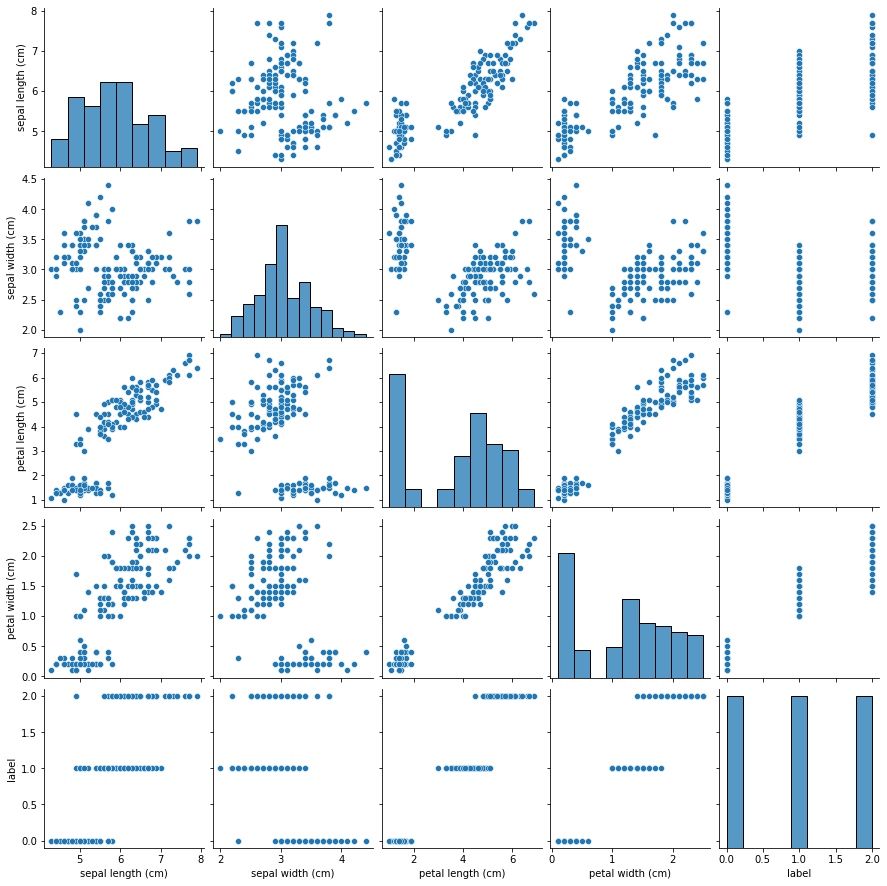

In [4]:
import seaborn as sns

sns.pairplot(X_y);

As with any other supervised machine learning method, we create a train and test set to learn and evaluate our model, respectively.

In [5]:
# stacking data X and labels y into one matrix
X_y_shuff = X_y.iloc[np.random.permutation(len(X_y))]

# we split train to test as 70:30
split_rate = 0.7
train, test = np.split(X_y_shuff, [int(split_rate*(X_y_shuff.shape[0]))])

X_train = train[train.columns[:-1]]
y_train = train[train.columns[-1]]

X_test = test[test.columns[:-1]]
y_test = test[test.columns[-1]]

y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [6]:
X_train

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
61,5.9,3.0,4.2,1.5
6,4.6,3.4,1.4,0.3
99,5.7,2.8,4.1,1.3
12,4.8,3.0,1.4,0.1
95,5.7,3.0,4.2,1.2
...,...,...,...,...
59,5.2,2.7,3.9,1.4
101,5.8,2.7,5.1,1.9
62,6.0,2.2,4.0,1.0
149,5.9,3.0,5.1,1.8


In [7]:
y_train

61     1
6      0
99     1
12     0
95     1
      ..
59     1
101    2
62     1
149    2
21     0
Name: label, Length: 105, dtype: int64

We will build up our decision tree algorithm in the pythonic way how we have done it previously as well by calling functions we define first in functions we define later. For quick evaluations of your implementations, however, we have also included one-line commands after each cell to see whether your implementation results in errors.

In our lectures, we have learnt how the Gini impurity of the labels $\boldsymbol y$ is calculated:
$$
\text{GI}(\boldsymbol y) = 1 - \sum_{i=1}^N \mathbb P (y_i)^2
$$

It's your turn to implement it in the next cell. We want to allow the code to consider samples with different weights, hence introduce an additional argument called `sample_weights`. The Iris data set we work with in this notebook has uniform sample weights, but other data sets you work with in the future could be different.

In [8]:
# EDIT THIS FUNCTION - DONE
def gini_impurity(y, sample_weights=None):
  """ 
  Calculate the gini impurity for labels.
  Arguments:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (float): the gini impurity for y.
  """
  if sample_weights is None:
      sample_weights = np.ones(y.shape[0]) / y.shape[0]
  
  gini = 1
  num = y.shape[0]  # number of labels
  label_counts = {}  # caculate different labels in y，and store in label_counts
  for i in range(num):
      if y[i] not in label_counts.keys():
          label_counts[y[i]] = 0
      label_counts[y[i]] += sample_weights[i]
  
  for key in label_counts:
      prob = float(label_counts[key]) / float(np.sum(sample_weights))
      gini -= prob**2 ## <-- EDIT THIS LINE - DONE

  return gini

In [9]:
# evaluate labels y
gini_impurity(y_train.to_numpy())

0.664489795918367

Next, we define a function to split the data set. This has not much use yet, but we will call it in later functions, e.g., in the next cell in `gini_purification`.

In [10]:
def split_dataset(X, y, column, value, sample_weights=None):
  """
  Return the split of data whose column-th feature equals value.
  Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      column: the column of the feature for splitting.
      value: the value of the column-th feature for splitting.
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (np.array): the subset of X whose column-th feature equals value.
      (np.array): the subset of y whose column-th feature equals value.
      (np.array): the subset of sample weights whose column-th feature equals value.
  """ 
  ret = []
  featVec = X[:, column]
  # selecting all columns of X except the "column" we are splitting on
  X = X[:,[i for i in range(X.shape[1]) if i!=column]]
  
  for i in range(len(featVec)):
      if featVec[i]==value:
          ret.append(i)
  
  sub_X = X[ret,:]
  sub_y = y[ret]
  sub_sample_weights = sample_weights[ret]

  return sub_X, sub_y, sub_sample_weights

We need a function to calculate the Gini impurity for every feature. Let's do this in the following cell by calling our previously defined two functions `split_dataset` and `gini_impurity`. 

In [11]:
# EDIT THIS FUNCTION - DONE
def gini_purification(X, y, column, sample_weights=None):
  """
  Calculate the resulted gini impurity given a vector of features.
  Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      column: the column of the feature for calculating. 0 <= column < D
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (float): the resulted gini impurity after splitting by this feature.
  """
  if sample_weights is None:
      sample_weights = np.ones(y.shape[0]) / y.shape[0]
  
  new_impurity = 0
  old_cost = gini_impurity(y, sample_weights)
  
  unique_vals = np.unique(X[:, column])
  new_cost = 0.0
  #split the values of i-th feature and calculate the cost 
  for value in unique_vals:
      ## EDIT THIS LINE below - DONE
      sub_X, sub_y, sub_sample_weights = split_dataset(X, y, column, value, sample_weights=sample_weights) 
      prob = np.sum(sub_sample_weights) / float(np.sum(sample_weights))
      new_cost += prob ** 2 ## <-- EDIT THIS LINE - DONE ???
  
  new_impurity = old_cost - new_cost # information gain

  return new_impurity

In [12]:
# evaluate for feature sepal width (cm)
gini_purification(X_train.to_numpy(), y_train.to_numpy(), 3)

0.5825850340136051

It's now time to choose the best feature to split by calling the function `gini_purification` for each feature.

In [13]:
## EDIT THIS FUNCTION - DONE
def choose_best_feature(X, y, sample_weights=None):
  """
  Choose the best feature to split according to criterion.
  Args:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (int): the column for the best feature
  """
  if sample_weights is None:
      sample_weights = np.ones(y.shape[0]) / y.shape[0]

  best_feature_idx = 0
  n_features = X.shape[1]    
  
  # use C4.5 algorithm
  best_gain_cost = 0.0
  for i in range(n_features):
      info_gain_cost = gini_purification(X, y, i, sample_weights=sample_weights)  ## <-- EDIT THIS LINE - DONE
      if info_gain_cost > best_gain_cost:
          best_gain_cost = info_gain_cost
          best_feature_idx = i                

  return best_feature_idx

In [14]:
# evaluate which feature is best
choose_best_feature(X_train.to_numpy(), y_train.to_numpy())

2

Now, we need a function that returns the label which appears the most in our label variable `y`.

In [15]:
def majority_vote(y, sample_weights=None):
  """
  Return the label which appears the most in y.
  Args:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (int): the majority label
  """
  if sample_weights is None:
      sample_weights = np.ones(y.shape[0]) / y.shape[0]
  
  majority_label = y[0]

  dict_num = {}
  for i in range(y.shape[0]):
      if y[i] not in dict_num.keys():
          dict_num[y[i]] = sample_weights[i]
      else:
          dict_num[y[i]] += sample_weights[i]
  
  majority_label = max(dict_num, key=dict_num.get)
  # end answer
  return majority_label

In [16]:
# evaluate it
majority_vote(y_train.to_numpy())

0

Finally, we can build the decision tree by using `choose_best_feature` to find the best feature to split the `X`, and `split_dataset` to get sub-trees.

In [17]:
# EDIT THIS FUNCTION
def build_tree(X, y, feature_names, depth, sample_weights=None, max_depth=10, min_samples_leaf=2):
  """Build the decision tree according to the data.
  Args:
      X: (np.array) training features, of shape (N, D).
      y: (np.array) vector of training labels, of shape (N,).
      feature_names (list): record the name of features in X in the original dataset.
      depth (int): current depth for this node.
      sample_weights: weights for each samples, of shape (N,).
  Returns:
      (dict): a dict denoting the decision tree. 
      Example:
          The first best feature name is 'title', and it has 5 different values: 0,1,2,3,4. 
          For 'title' == 4, the next best feature name is 'pclass', we continue split the remain data. 
          If it comes to the leaf, we use the majority_label by calling majority_vote.
          
          mytree = {
              'title': {
                  0: subtree0,
                  1: subtree1,
                  2: subtree2,
                  3: subtree3,
                  4: {
                      'pclass': {
                          1: majority_vote([1, 1, 1, 1]) # which is 1, majority_label
                          2: majority_vote([1, 0, 1, 1]) # which is 1
                          3: majority_vote([0, 0, 0]) # which is 0
                      }
                  }
              }
          }
  """
  mytree = dict()

  # include a clause for the cases where (i) no feature, (ii) all lables are the same, 
  # (iii) depth exceed, or (iv) X is too small
  if len(feature_names)==0 or len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf: 
      return majority_vote(y, sample_weights)
  
  else:
    best_feature_idx = choose_best_feature(X, y, sample_weights=sample_weights)  ## <-- EDIT THIS LINE - DONE
    best_feature_name = feature_names[best_feature_idx]
    feature_names = feature_names[:]
    feature_names.remove(best_feature_name)
    
    mytree = {best_feature_name:{}}
    unique_vals = np.unique(X[:, best_feature_idx])
    for value in unique_vals:
        ## <-- EDIT THIS LINE below - DONE
        sub_X, sub_y, sub_sample_weights = split_dataset(X, y, best_feature_idx, value, sample_weights=sample_weights)  
        ## <-- EDIT THIS LINE below (hint: use depth+1 as the depth) - DONE
        mytree[best_feature_name][value] = build_tree(sub_X, sub_y, feature_names, depth+1, sample_weights=sub_sample_weights) 

    return mytree

We define a wrapper function that we call `train` to call this `build_tree` function with the appropriate arguments.

In [18]:
def train(X, y, sample_weights=None):
  """
  Build the decision tree according to the training data.
  Args:
      X: (pd.Dataframe) training features, of shape (N, D). Each X[i] is a training sample.
      y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] <= C. Here C = 1.
      sample_weights: weights for each samples, of shape (N,).
  """
  if sample_weights is None:
      # if the sample weights is not provided, we assume the samples have uniform weights
      sample_weights = np.ones(X.shape[0]) / X.shape[0]
  else:
      sample_weights = np.array(sample_weights) / np.sum(sample_weights)

  feature_names = X.columns.tolist()
  X = np.array(X)
  y = np.array(y)
  tree = build_tree(X, y, feature_names, depth=1, sample_weights=sample_weights)
  return tree

In [19]:
# fit the decision tree with training data
tree = train(X_train, y_train)

Now, we want to use this fitted decision tree to make predictions for our test set `X_test`. To do so, we first define a function `classify` that takes each single data point `x` as an argument. We will write a wrapper function `predict` that calls this `classify` function.

In [20]:
def classify(tree, x):
  """
  Classify a single sample with the fitted decision tree.
  Args:
      x: ((pd.Dataframe) a single sample features, of shape (D,).
  Returns:
      (int): predicted testing sample label.
  """
  feature_name = list(tree.keys())[0] # first element
  second_dict = tree[feature_name]            
  key = x.loc[feature_name]
  if key not in second_dict:
      key = np.random.choice(list(second_dict.keys()))
  value_of_key = second_dict[key]
  if isinstance(value_of_key, dict):
      label = classify(value_of_key, x)
  else:
      label=value_of_key
  return label

In [21]:
def predict(X):
  """
  Predict classification results for X.
  Args:
      X: (pd.Dataframe) testing sample features, of shape (N, D).
  Returns:
      (np.array): predicted testing sample labels, of shape (N,).
  """
  if len(X.shape)==1:
      return classify(tree, X)
  else:
      results=[]
      for i in range(X.shape[0]):
          results.append(classify(tree, X.iloc[i, :]))
      return np.array(results)

To evaluate how well the tree can generalise to unseen data in `X_test`, we define a short function that computes the mean accuracy.

In [22]:
## EDIT THIS FUNCTION - DONE
def score(X_test, y_test):
  y_pred = predict(X_test) ## <-- EDIT THIS LINE - DONE
  return np.float(sum(y_pred==y_test)) / float(len(y_test))

In [23]:
print('Training accuracy:', score(X_train, y_train))
print('Test accuracy:', score(X_test, y_test))

Training accuracy: 1.0
Test accuracy: 0.8444444444444444


#### Questions:
1. What do the results above tell you? Has the decision tree you implemented overfitted to the training data?
- That the decision tree has a good accuracy, doesn't seem to be overfitting as accuracy seems to be over 80% on average over repeated trials.
2. If so, what can you change to counteract this problem?
- possibly adjusting the stopping criterion such as the minimum leaf size
3. Can you think of other information criteria than the Gini impurity? If so, try implementing them and compare it to the decision tree with the Gini impurity.
- The cross entropy (generally doesn't matter which one we use, NB computing logs maybe computationally intensive)
